In [1]:
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)
df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':1 ,'B':0})
print(df.shape)

(569, 32)


In [3]:
arr2D = df.to_numpy()
columnIndex = 1
sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
numZeros = list(sortedArr[:, 1]).count(0)
benignDF, malignantDF = pd.DataFrame(sortedArr[0:numZeros]), pd.DataFrame(sortedArr[numZeros:])
benignDF.columns = cols
malignantDF.columns = cols


In [4]:
for i in benignDF[cols[2:]]:
    print('-'*40)
    print('Column: {}'.format(i))
    print(' Bening - Min: {}, Max: {}, Mean: {:.02f}, Std Dev: {:.02f}'.format(min(benignDF[i]), max(benignDF[i]), sum(benignDF[i])/len(benignDF[i]), np.std(benignDF[i])))
    print(' Malignant - Min: {}, Max: {}, Mean: {:.02f}, Std Dev: {:.02f}'.format(min(malignantDF[i]), max(malignantDF[i]), sum(malignantDF[i])/len(malignantDF[i]), np.std(malignantDF[i])))

----------------------------------------
Column: radius
 Bening - Min: 6.981, Max: 17.85, Mean: 12.15, Std Dev: 1.78
 Malignant - Min: 10.95, Max: 28.11, Mean: 17.46, Std Dev: 3.20
----------------------------------------
Column: texture
 Bening - Min: 9.71, Max: 33.81, Mean: 17.91, Std Dev: 3.99
 Malignant - Min: 10.38, Max: 39.28, Mean: 21.60, Std Dev: 3.77
----------------------------------------
Column: perimeter
 Bening - Min: 43.79, Max: 114.6, Mean: 78.08, Std Dev: 11.79
 Malignant - Min: 71.9, Max: 188.5, Mean: 115.37, Std Dev: 21.80
----------------------------------------
Column: area
 Bening - Min: 143.5, Max: 992.1, Mean: 462.79, Std Dev: 134.10
 Malignant - Min: 361.6, Max: 2501.0, Mean: 978.38, Std Dev: 367.07
----------------------------------------
Column: smoothness
 Bening - Min: 0.05263, Max: 0.1634, Mean: 0.09, Std Dev: 0.01
 Malignant - Min: 0.07371, Max: 0.1447, Mean: 0.10, Std Dev: 0.01
----------------------------------------
Column: compactness
 Bening - Min: 0

In [5]:
import matplotlib
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
import warnings #to remove the warnings
import random
import sys
sys.path.append('../../_hepers_')
from genNewVals import generateNewFeatureValMultiple
from subsampleData import subsample
from models import trainModels
from genFillNulls import *
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler



def trainF1CrossValModels(X, y, numFolds):
    nb = GaussianNB()
    nbScores = cross_val_score(nb, X, y, cv=numFolds, scoring='f1')
    print('Completed Naive Bayes')
    logisticClassifier = LogisticRegression()
    logScores = cross_val_score(logisticClassifier, X, y, cv=numFolds, scoring='f1')
    print('Completed Logistic Regression')
    svclassifier = SVC(kernel='linear', max_iter = 5000000)
    svmScores = cross_val_score(svclassifier, X, y, cv=numFolds, scoring='f1')
    print('Completed SVM')
    clf = DecisionTreeClassifier(random_state = 42)
    dtScrores = cross_val_score(clf, X, y, cv=numFolds, scoring='f1')
    print('Completed Decision Tree')
    votingCl = VotingClassifier(
                estimators =    [('gnb', GaussianNB()),
                                ('lr',  LogisticRegression()),
                                ('svm', SVC(kernel='linear', max_iter = 5000000)),
                                ('dtc', DecisionTreeClassifier(random_state=42))], 
                voting='hard')
    voteScores = cross_val_score(votingCl, X, y, cv=numFolds, scoring='f1')
    print('Completed Voting Classification')
    return nbScores, logScores, svmScores, dtScrores, voteScores

def generateSupplementalData(X_train, y_train, numBenign = 0, numMalig = 0):
    trainingSet = X_train.copy()
    trainingSet['Diagnosis'] = y_train
    arr2D = trainingSet.to_numpy()
    columnIndex = -1
    sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
    numZeros = list(sortedArr[:, columnIndex]).count(0)
    benignDF, malignantDF = pd.DataFrame(sortedArr[0:numZeros]), pd.DataFrame(sortedArr[numZeros:])
    benignDF.columns, malignantDF.columns = trainingSet.columns, trainingSet.columns
    numBenignNeeded = numBenign - benignDF.shape[0]
    numMaligNeeded = numMalig - malignantDF.shape[0]

    #Storing all Raw Benign Data to Later be Merged with Synthetic
    preExistingBenign = []
    for index, row in benignDF.iterrows():
        preExistingBenign.append(list(row))
    preExistingBenign = np.array(preExistingBenign)
    
    #Storing all Raw Malignant Data to Later be Merged with Synthetic
    preExistingMalig = []
    for index, row in malignantDF.iterrows():
        preExistingMalig.append(list(row))
    preExistingMalig = np.array(preExistingMalig)

    #Generating New Data
    benignPatients = []
    for col in benignDF.columns:
        benignPatients.append(generateNewFeatureValMultiple(benignDF, col, 25, numBenignNeeded))
    benignPatients = np.array(benignPatients).T
    malignangPatients = []
    for col in malignantDF.columns:
        malignangPatients.append(generateNewFeatureValMultiple(malignantDF, col, 25, numMaligNeeded))
    malignangPatients = np.array(malignangPatients).T

    #Combining Real Data and Synthetic Data, or Only using Real Data in the case of majority class
    if np.array(benignPatients).shape[0] > 0:
        benignPatients = np.vstack((preExistingBenign, np.array(benignPatients)))
    else:
        benignPatients = preExistingBenign
    if np.array(malignangPatients).shape[0] > 0:
        malignangPatients = np.vstack((preExistingMalig, np.array(malignangPatients)))
    else:
        benignPatients = preExistingBenign
    jointArray = np.vstack((benignPatients,malignangPatients))
    finalDataset = pd.DataFrame(jointArray, columns = benignDF.columns) 

    #Reporting Summary
    print('Final Dataset Composition: {}'.format(finalDataset.shape))
    print(' - Benign:')
    print('   -   New Benign Instances Created: {}'.format(numBenignNeeded))
    print('   -   Old Benign Instances Used: {}'.format(preExistingBenign.shape[0]))
    print(' - Malignant:')
    print('   -   New Malignant Instances Created: {}'.format(numMaligNeeded))
    print('   -   Old Malignant Instances Used: {}'.format(preExistingMalig.shape[0]))
    return finalDataset

def printOutputs(naiveBayesScore, LogScore, SVMScore, DTScore, VoteScore):
    print('NB Mean Scores: {}'.format(np.mean(naiveBayesScore)))
    print('LR Mean Scores: {}'.format(np.mean(LogScore)))
    print('SVM Mean Scores: {}'.format(np.mean(SVMScore)))
    print('DT Mean Scores: {}'.format(np.mean(DTScore)))
    print('VC Mean Scores: {}'.format(np.mean(VoteScore)))

def prepWDBC():
    cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']

    df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)

    df.columns = cols
    df['Diagnosis'] = df['Diagnosis'].map(
                    {'M':1,'B':0})
    for i in df:
        df[i] = df[i].astype(np.float)

    colsV2 = cols[2:]
    colsV2.append(cols[1])
    df = df[colsV2]
    return df, colsV2

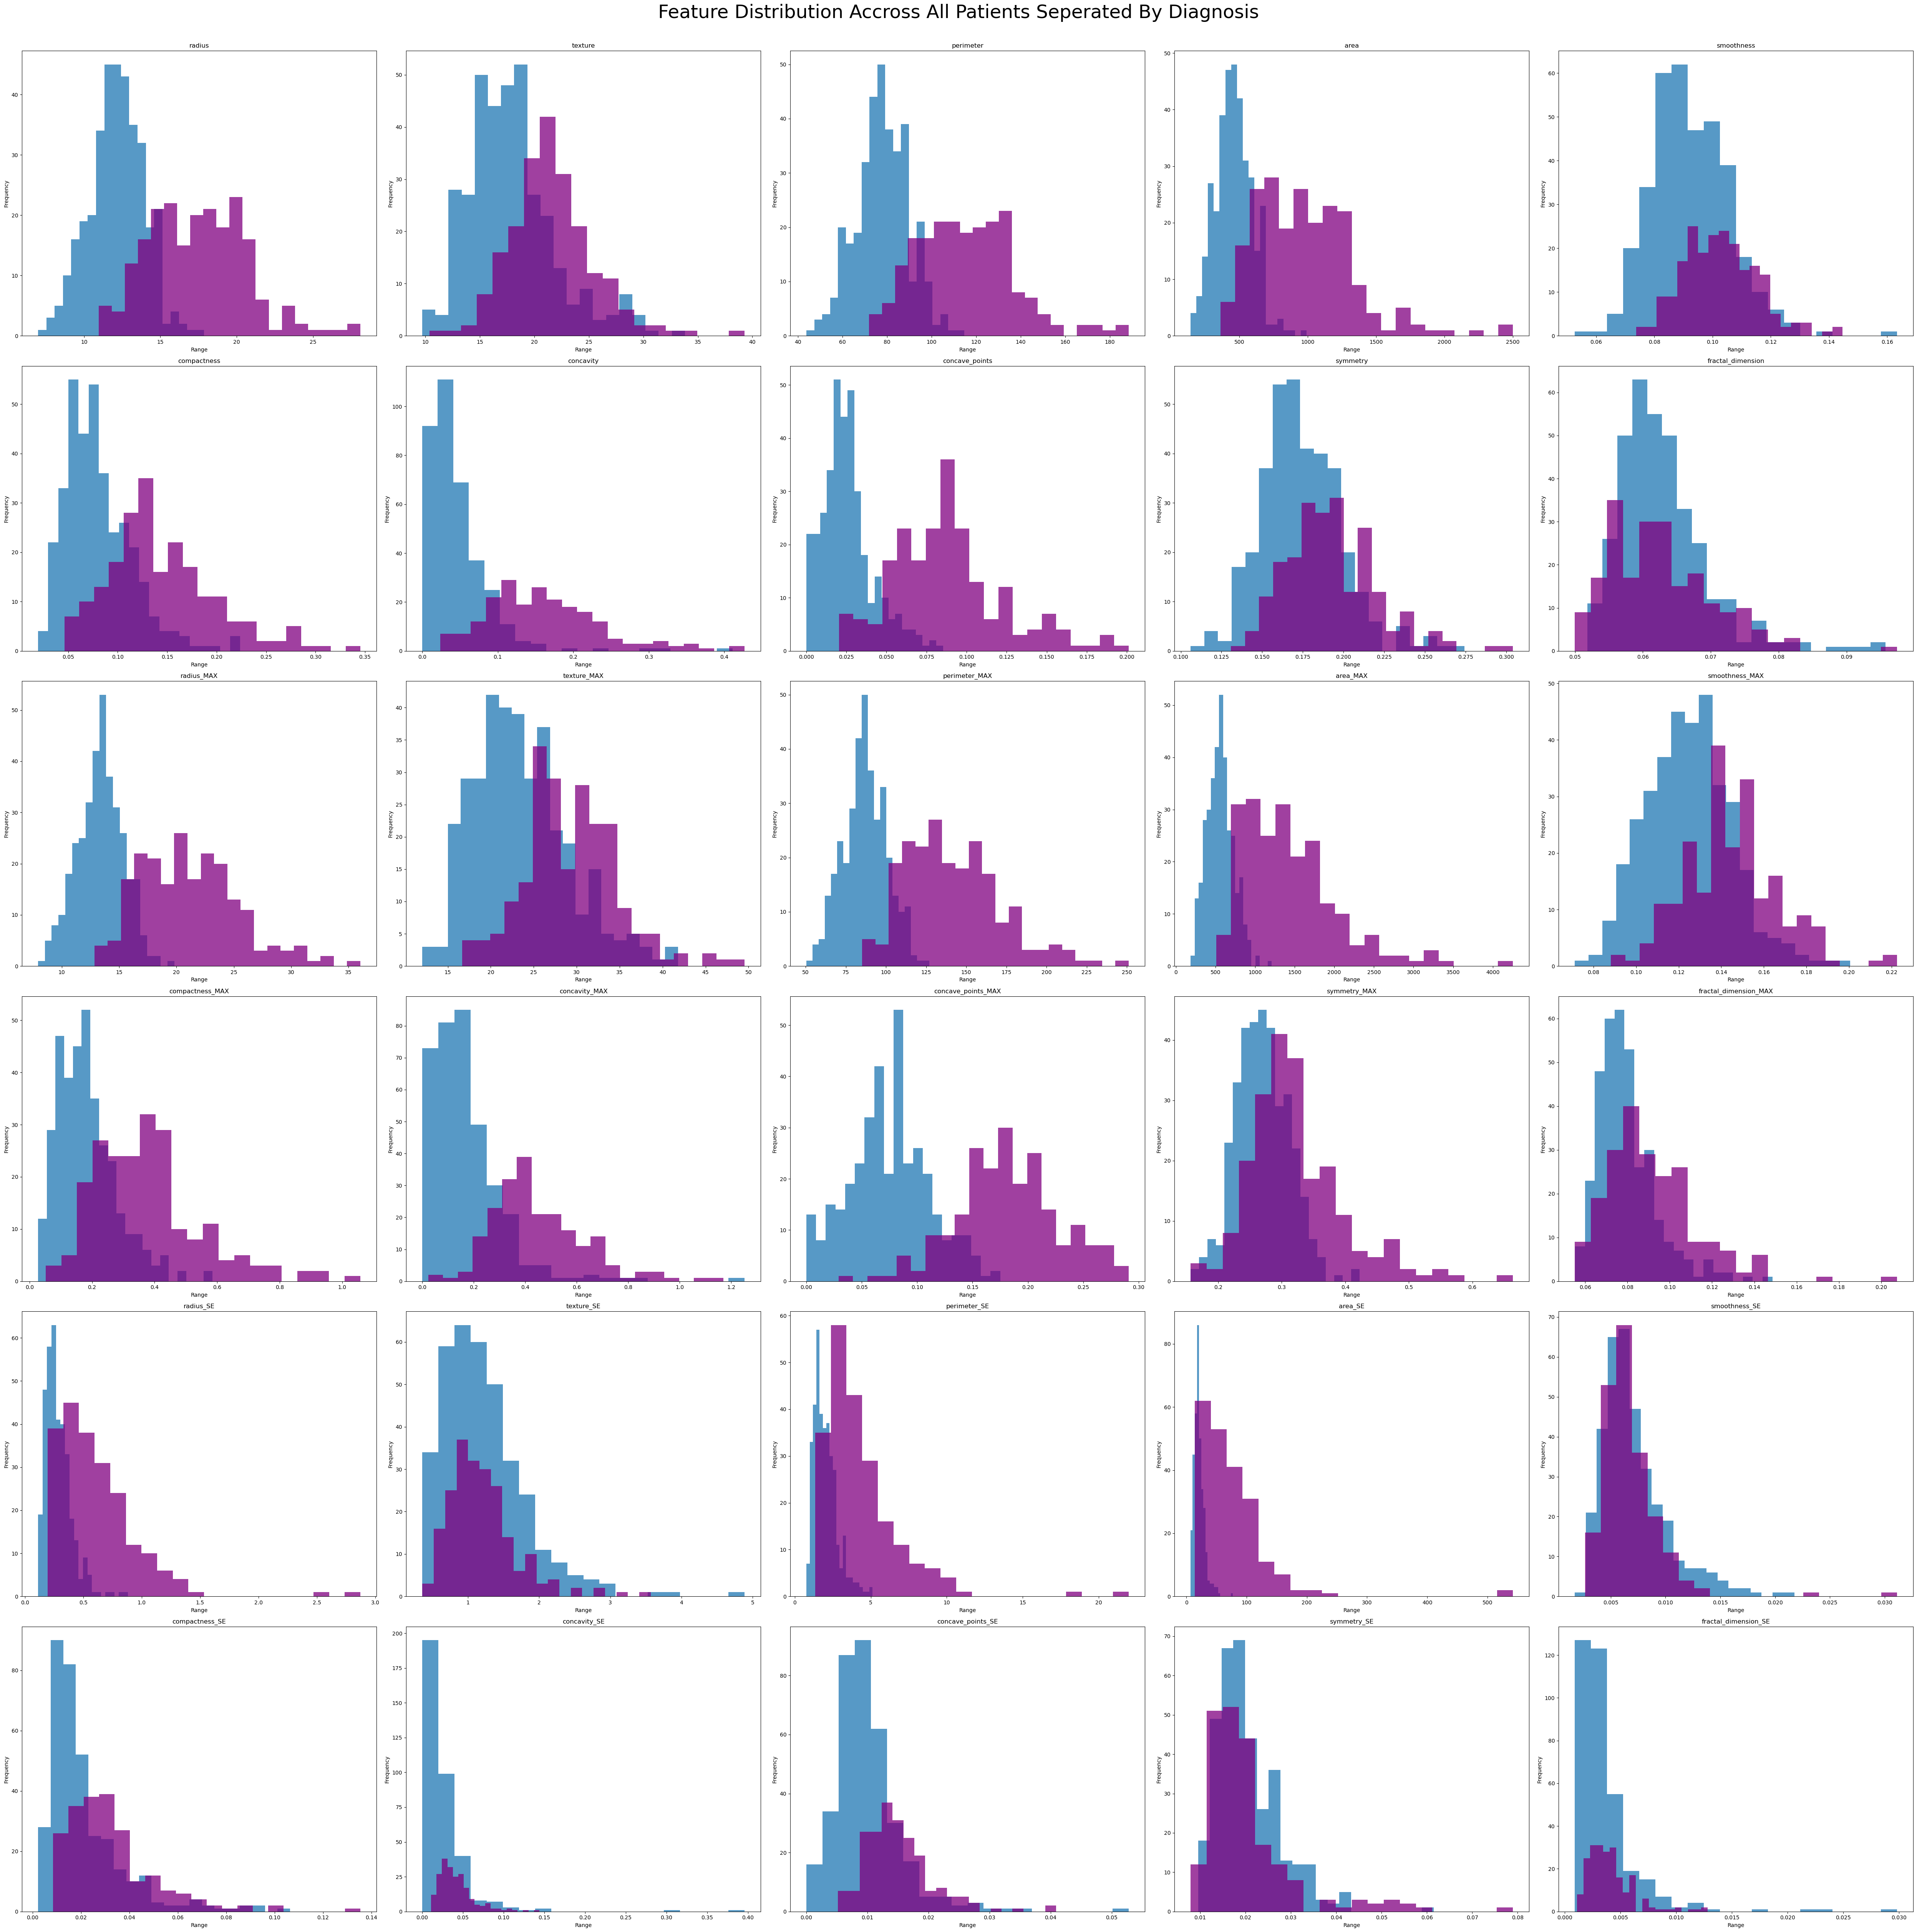

In [6]:
fig, ax = plt.subplots(6, 5, figsize = (50, 50))
colGraphs = cols[2:]
colGraphs = colGraphs[:10] + colGraphs[20:] + colGraphs[10:20]
plt.suptitle('Feature Distribution Accross All Patients Seperated By Diagnosis', fontsize=35, y=1.005)
counter = 0
for i in colGraphs:
    beningHist, benignBins = np.histogram(benignDF[i], bins=20)
    maligHist, maligBins = np.histogram(malignantDF[i], bins=20)
    
    ax[int(counter / 5), (counter % 5)].hist(benignDF[i], bins = benignBins, alpha = 0.75)
    ax[int(counter / 5), (counter % 5)].hist(malignantDF[i], bins = maligBins, alpha = 0.75, color = 'purple')
    ax[int(counter / 5), (counter % 5)].set_title(i)
    ax[int(counter / 5), (counter % 5)].set_ylabel('Frequency')
    ax[int(counter / 5), (counter % 5)].set_xlabel('Range')
    counter += 1

fig.tight_layout()
plt.show()

Final Dataset Composition: (3999, 31)
 - Benign:
   -   New Benign Instances Created: 2152
   -   Old Benign Instances Used: 357
 - Malignant:
   -   New Malignant Instances Created: 1278
   -   Old Malignant Instances Used: 212


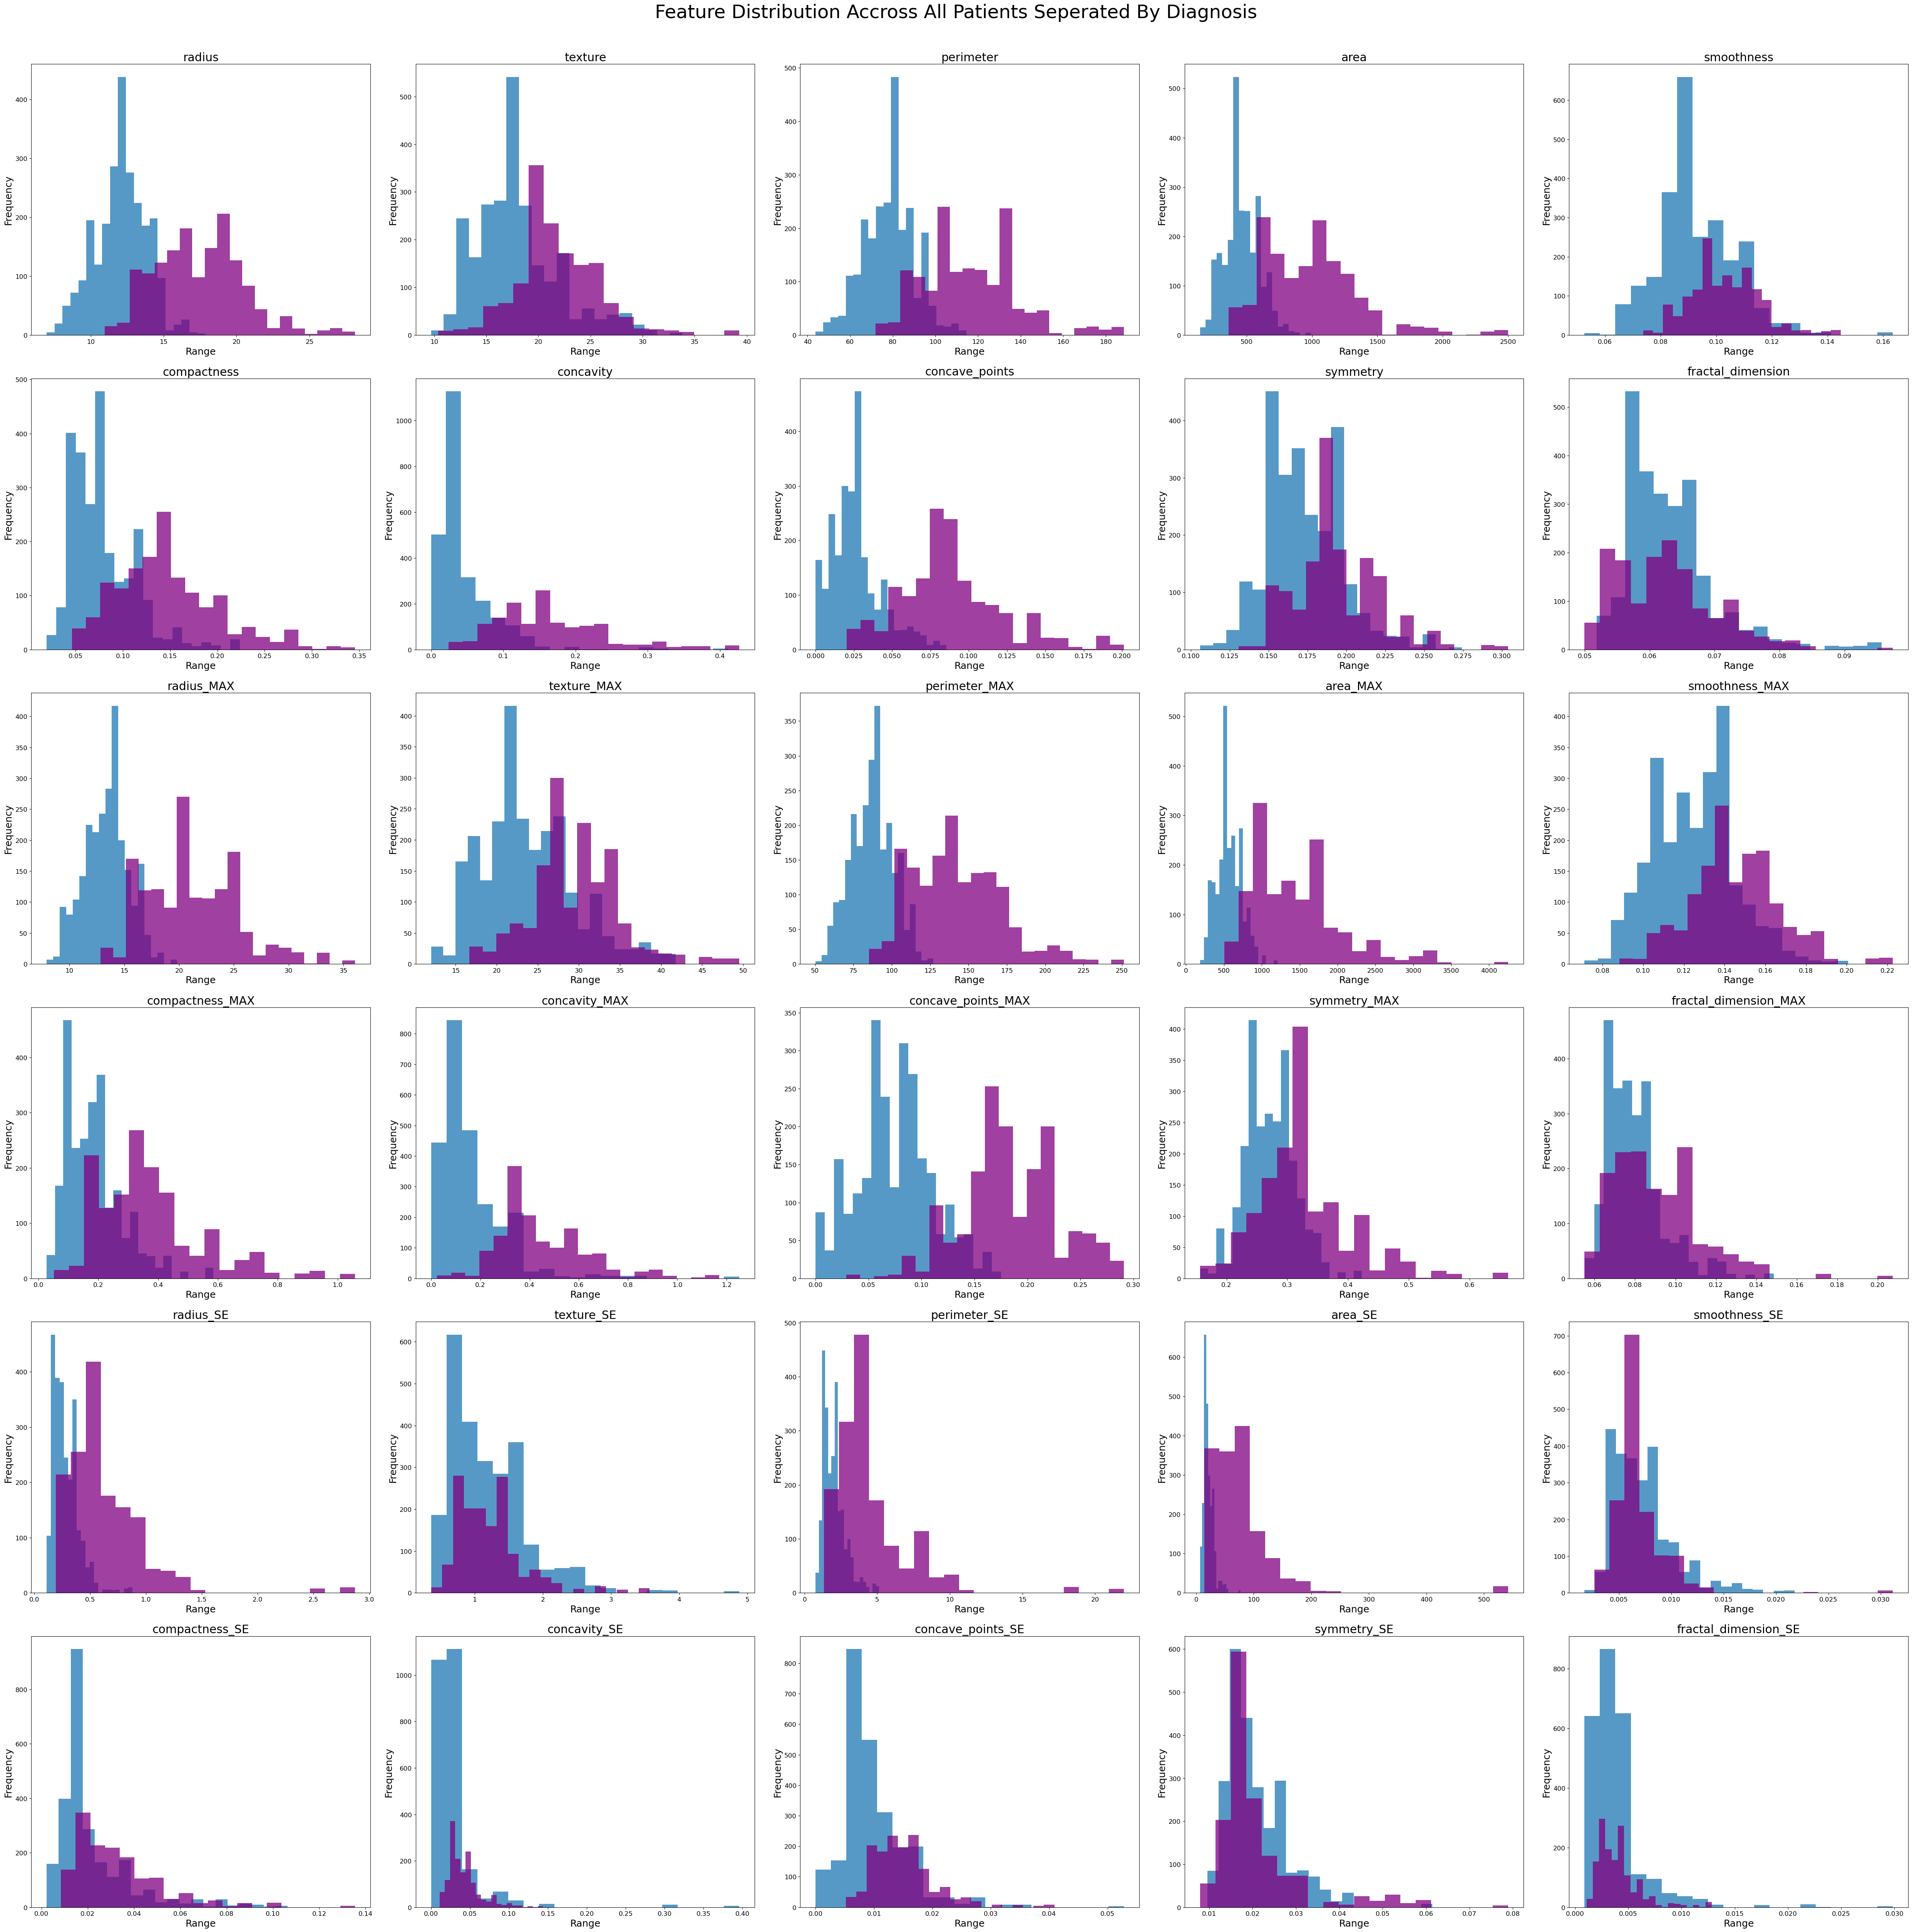

6.981 17.85
6.981 17.85


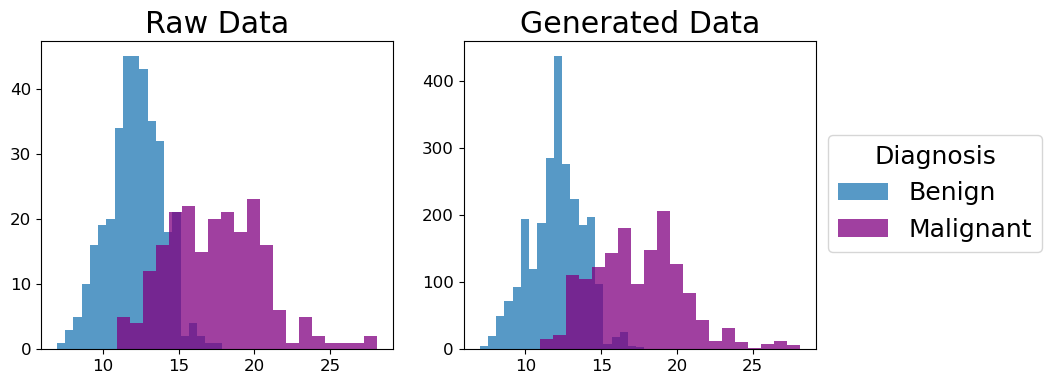

In [45]:

df, cols = prepWDBC()

X = df[cols[:-1]]
y = df[cols[-1]]
percent = (len(y) - sum(y)) / len(y)
finalDataset = generateSupplementalData(X, y, numBenign = int(4000 * percent), numMalig = int(4000 * (1 - percent)))
X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]

trainingSet = X.copy()
trainingSet['Diagnosis'] = y
arr2D = trainingSet.to_numpy()
columnIndex = -1
sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
numZeros = list(sortedArr[:, columnIndex]).count(0)
benignDF2, malignantDF2 = pd.DataFrame(sortedArr[0:numZeros]), pd.DataFrame(sortedArr[numZeros:])
benignDF2.columns, malignantDF2.columns = cols, cols


fig, ax = plt.subplots(6, 5, figsize = (50, 50))
colGraphs = cols[:-1]
colGraphs = colGraphs[:10] + colGraphs[20:] + colGraphs[10:20]
plt.suptitle('Feature Distribution Accross All Patients Seperated By Diagnosis', fontsize=35, y=1.005)
counter = 0
for i in colGraphs:
    beningHist, benignBins = np.histogram(benignDF2[i], bins=20)
    maligHist, maligBins = np.histogram(malignantDF2[i], bins=20)
    
    ax[int(counter / 5), (counter % 5)].hist(benignDF2[i], bins = benignBins, alpha = 0.75)
    ax[int(counter / 5), (counter % 5)].hist(malignantDF2[i], bins = maligBins, alpha = 0.75, color = 'purple')
    ax[int(counter / 5), (counter % 5)].set_title(i)
    ax[int(counter / 5), (counter % 5)].set_ylabel('Frequency')
    ax[int(counter / 5), (counter % 5)].set_xlabel('Range')
    counter += 1

fig.tight_layout()
plt.show()




print(min(benignDF['radius']), max(benignDF['radius']))
print(min(benignDF2['radius']), max(benignDF2['radius']))

'''plt.rcParams["figure.figsize"] = (5, 5)
plt.hist(benignDF['radius'], bins=20, alpha=0.75, color = 'C0', label='Benign')
plt.hist(malignantDF['radius'], bins=20, alpha=0.75, color = 'purple', label='Malignant')
plt.ylabel('Occurences')
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.legend(title='Diagnosis',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




plt.hist(benignDF2['radius'], bins=20, alpha=0.75, color = 'C0', label='Benign')
plt.hist(malignantDF2['radius'], bins=20, alpha=0.75, color = 'purple', label='Malignant')
plt.ylabel('Occurences')
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.legend(title='Diagnosis',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()'''



fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
#fig.suptitle('Horizontally stacked subplots')
plt.rcParams.update({'font.size': 18})
ax1.hist(benignDF['radius'], bins=20, alpha=0.75, color = 'C0', label='Benign')
ax1.hist(malignantDF['radius'], bins=20, alpha=0.75, color = 'purple', label='Malignant')
ax1.set_title('Raw Data')
ax2.hist(benignDF2['radius'], bins=20, alpha=0.75, color = 'C0')#, label='Benign')
ax2.hist(malignantDF2['radius'], bins=20, alpha=0.75, color = 'purple')#, label='Malignant')
ax2.set_title('Generated Data')
fig.legend(title='Diagnosis',loc='center left', bbox_to_anchor=(0.9, 0.5))